We extract and prepare data from the [2019 cell reports data](https://www.cell.com/cell-reports/fulltext/S2211-1247(18)31982-X) for our 4D cell classification. The 2019 cell reports data has 28 WT-EMB embryos, for each cell, we can extract its trajectory, mother cell, daughter cells and division orientations.

To do this, we can first get all unique cell names across 28 embryos, then:
1. Build [lineage tree](http://wormweb.org/celllineage#c=P4a&z=1) based on cell names: <br/>
   there are only 6 special naming cases in division: `{P0:[AB, P1], P1:[EMS, P2], P2:[C, P3], P3:[D, P4], P4:[Z3, Z2], EMS:[E, MS]}`; <br/>
   in all the other cases, daughter cells are named by appending `a/p, l/r, d/v` of their mother cell, where `a/p` are the majority divisions.   
2. Extract trajectory and division info based on cell names and lineage tree


# Build lineage tree

In [1]:
import numpy as np 
import pandas as pd 
import networkx as nx 
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from pathlib import Path
from tqdm import tqdm
import time
import json
import pickle
from collections import deque, defaultdict
import _utilities

In [2]:
# Extract all cell names
tracking_folder = './Cell-lineage-and-position-WT-compressed_canonical_orientation/'
voxel_size_zyx = (1,0.22,0.22) # um, in ZYX order for anisotropic voxel
temporal_resolution = 1.25 # min per frame
# Build Atlas
atlas = {}
for embryo_index in range(1,29):
    embryo_name = f'WT-EMB{str(embryo_index).zfill(2)}'
    tracking_GT = pd.read_csv(f'{tracking_folder}/{embryo_name}.txt', delimiter='\t', index_col=[0])
    tracking_GT['Z'], tracking_GT['Y'], tracking_GT['X'] = tracking_GT['Z']*voxel_size_zyx[0], tracking_GT['Y']*voxel_size_zyx[1], tracking_GT['X']*voxel_size_zyx[2] 
    atlas[embryo_name] = tracking_GT

In [3]:
atlas.keys()

dict_keys(['WT-EMB01', 'WT-EMB02', 'WT-EMB03', 'WT-EMB04', 'WT-EMB05', 'WT-EMB06', 'WT-EMB07', 'WT-EMB08', 'WT-EMB09', 'WT-EMB10', 'WT-EMB11', 'WT-EMB12', 'WT-EMB13', 'WT-EMB14', 'WT-EMB15', 'WT-EMB16', 'WT-EMB17', 'WT-EMB18', 'WT-EMB19', 'WT-EMB20', 'WT-EMB21', 'WT-EMB22', 'WT-EMB23', 'WT-EMB24', 'WT-EMB25', 'WT-EMB26', 'WT-EMB27', 'WT-EMB28'])

In [4]:
# Extract all cells
all_cells = set()
for embryo in atlas:
    all_cells.update(atlas[embryo]['cell_name'])
print(len(all_cells))

781


In [5]:
'P0' in all_cells # this means we can get an intact lineage tree starting from P0

True

In [6]:
'Z2' in all_cells, 'Z3' in all_cells

(True, True)

In [7]:
lineage_tree_dict_of_lists = {'P0':['AB', 'P1'], 'P1':['EMS', 'P2'], 'P2':['C', 'P3'], 'P3':['D', 'P4'], 'P4':['Z3', 'Z2'], 'EMS':['E', 'MS'], 'Z2':[], 'Z3':[]}
# we can use BFS to build the graph
frontiers = deque(['AB','C','D','E','MS'])
while frontiers:
    for i in range(len(frontiers)):
        node = frontiers.popleft()
        potential_daughter_cells = [f'{node}a',f'{node}p',f'{node}l',f'{node}r',f'{node}d',f'{node}v']
        daughter_nodes = [cell for cell in potential_daughter_cells if cell in all_cells]
        lineage_tree_dict_of_lists[node] = daughter_nodes 
        frontiers.extend(daughter_nodes)

In [8]:
lineage_tree_dict_of_lists

{'P0': ['AB', 'P1'],
 'P1': ['EMS', 'P2'],
 'P2': ['C', 'P3'],
 'P3': ['D', 'P4'],
 'P4': ['Z3', 'Z2'],
 'EMS': ['E', 'MS'],
 'Z2': [],
 'Z3': [],
 'AB': ['ABa', 'ABp'],
 'C': ['Ca', 'Cp'],
 'D': ['Da', 'Dp'],
 'E': ['Ea', 'Ep'],
 'MS': ['MSa', 'MSp'],
 'ABa': ['ABal', 'ABar'],
 'ABp': ['ABpl', 'ABpr'],
 'Ca': ['Caa', 'Cap'],
 'Cp': ['Cpa', 'Cpp'],
 'Da': ['Daa', 'Dap'],
 'Dp': ['Dpa', 'Dpp'],
 'Ea': ['Eal', 'Ear'],
 'Ep': ['Epl', 'Epr'],
 'MSa': ['MSaa', 'MSap'],
 'MSp': ['MSpa', 'MSpp'],
 'ABal': ['ABala', 'ABalp'],
 'ABar': ['ABara', 'ABarp'],
 'ABpl': ['ABpla', 'ABplp'],
 'ABpr': ['ABpra', 'ABprp'],
 'Caa': ['Caaa', 'Caap'],
 'Cap': ['Capa', 'Capp'],
 'Cpa': ['Cpaa', 'Cpap'],
 'Cpp': ['Cppa', 'Cppp'],
 'Daa': ['Daaa', 'Daap'],
 'Dap': ['Dapa', 'Dapp'],
 'Dpa': ['Dpaa', 'Dpap'],
 'Dpp': ['Dppa', 'Dppp'],
 'Eal': ['Eala', 'Ealp'],
 'Ear': ['Eara', 'Earp'],
 'Epl': ['Epla', 'Eplp'],
 'Epr': ['Epra', 'Eprp'],
 'MSaa': ['MSaaa', 'MSaap'],
 'MSap': ['MSapa', 'MSapp'],
 'MSpa': ['MSpaa', 

In [9]:
import json
with open( './lineage_tree.json', 'w') as f:
   json.dump(lineage_tree_dict_of_lists, f)

In [10]:
len(lineage_tree_dict_of_lists) == len(all_cells)

True

In [11]:
np.unique([len(lineage_tree_dict_of_lists[node]) for node in lineage_tree_dict_of_lists])

array([0, 2])

In [12]:
len([node for node in lineage_tree_dict_of_lists if len(lineage_tree_dict_of_lists[node])==0]), [node for node in lineage_tree_dict_of_lists if len(lineage_tree_dict_of_lists[node])==0]

(391,
 ['Z2',
  'Z3',
  'Daaa',
  'Daap',
  'Dpaa',
  'Dpap',
  'Caapa',
  'Dapaa',
  'Dapap',
  'Dappa',
  'Dappp',
  'Dppaa',
  'Dppap',
  'Dpppa',
  'Dpppp',
  'Ealaa',
  'Ealap',
  'Ealpa',
  'Ealpp',
  'Earaa',
  'Earap',
  'Earpa',
  'Earpp',
  'Eplaa',
  'Eplap',
  'Eplpa',
  'Eplpp',
  'Epraa',
  'Eprap',
  'Eprpa',
  'Eprpp',
  'Caaaaa',
  'Caaaap',
  'Caaapa',
  'Caaapp',
  'Caappd',
  'Caappv',
  'Capaaa',
  'Capaap',
  'Capapa',
  'Capapp',
  'Cappaa',
  'Cappap',
  'Capppa',
  'Capppp',
  'Cpaaaa',
  'Cpaaap',
  'Cpaapa',
  'Cpaapp',
  'Cpapaa',
  'Cpapap',
  'Cpappd',
  'Cpappv',
  'Cppaaa',
  'Cppaap',
  'Cppapa',
  'Cppapp',
  'Cpppaa',
  'Cpppap',
  'Cppppa',
  'Cppppp',
  'MSaappa',
  'MSpaapp',
  'MSpappa',
  'MSaaaaaa',
  'MSaaaapa',
  'MSaaaapp',
  'MSaaapaa',
  'MSaaapap',
  'MSaaappa',
  'MSaaappp',
  'MSaapaaa',
  'MSaapaap',
  'MSaapapa',
  'MSaapapp',
  'MSaapppa',
  'MSaapppp',
  'MSapaaaa',
  'MSapaaap',
  'MSapaapa',
  'MSapaapp',
  'MSapapaa',
  'MSapapap'

In [13]:
[node for node in lineage_tree_dict_of_lists if node.startswith('Da')]

['Da',
 'Daa',
 'Dap',
 'Daaa',
 'Daap',
 'Dapa',
 'Dapp',
 'Dapaa',
 'Dapap',
 'Dappa',
 'Dappp']

In [14]:
lineage_tree = nx.from_dict_of_lists(lineage_tree_dict_of_lists, create_using=nx.DiGraph)

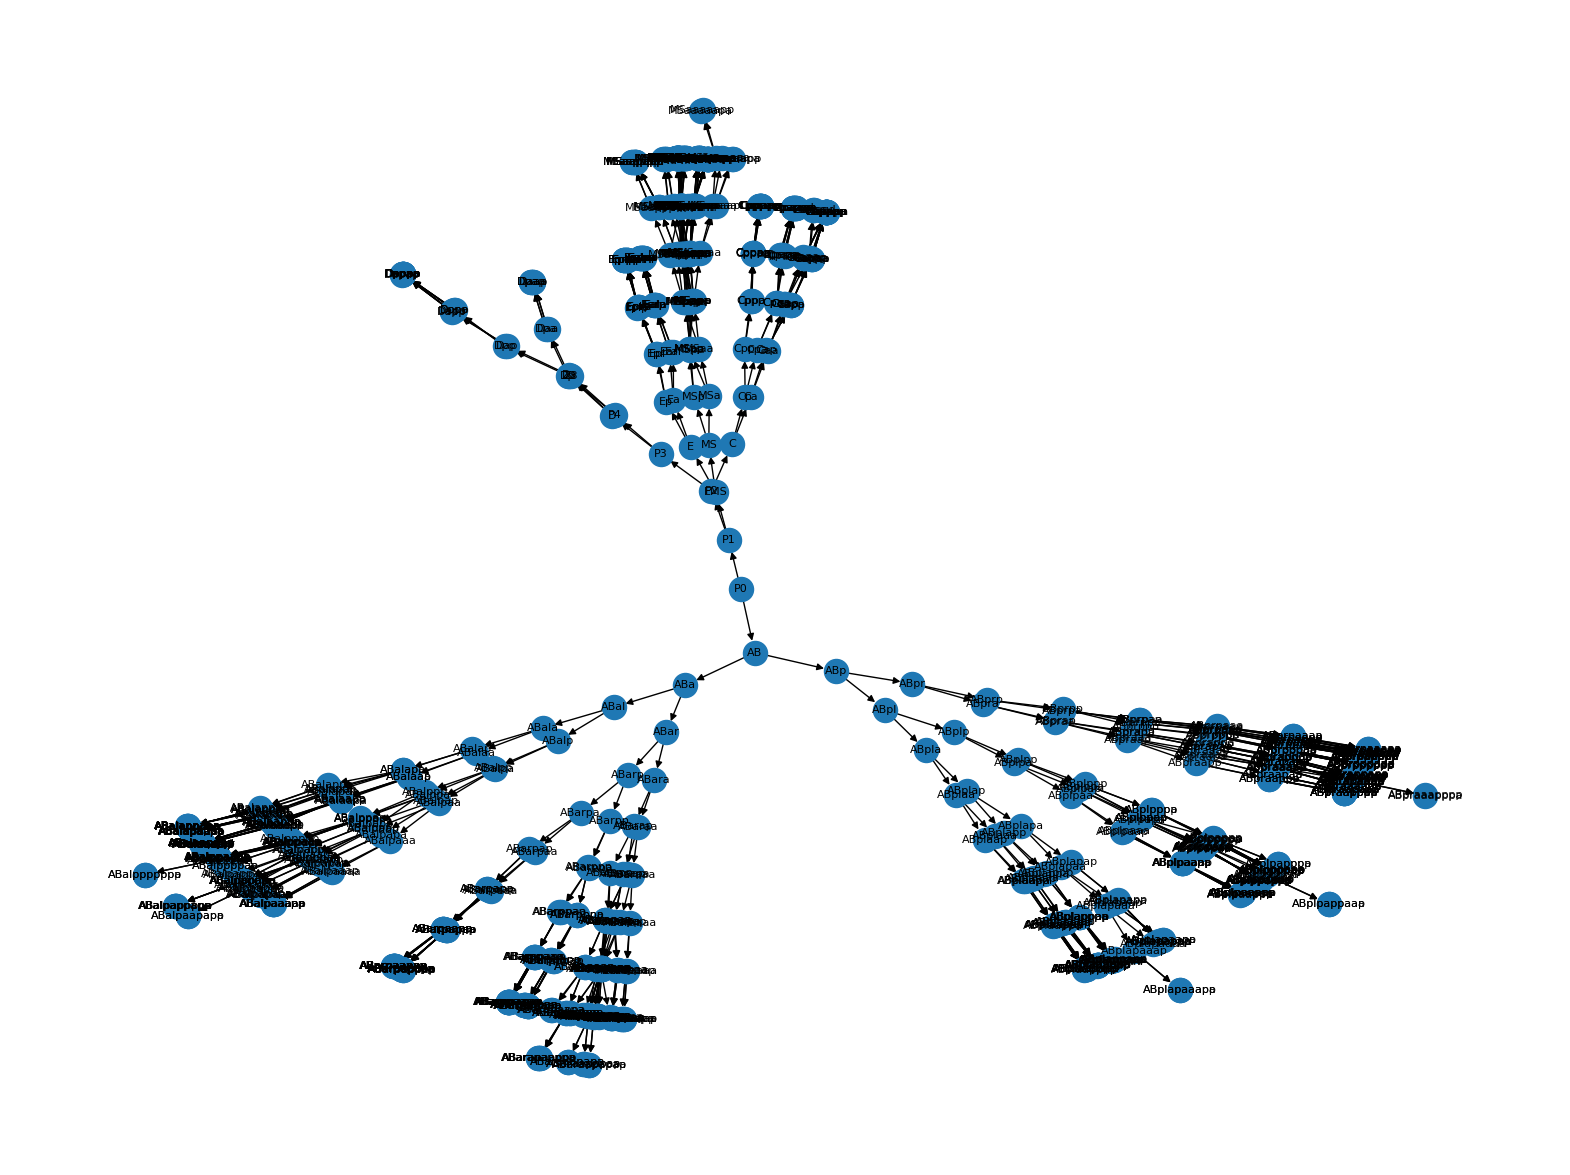

In [15]:
# Visualize the trie
fig, ax = plt.subplots(figsize = (20,15))
nx.draw(lineage_tree, pos=nx.kamada_kawai_layout(lineage_tree), with_labels=True, ax=ax, font_size=8)

We can see we successfully build the lineage tree.

# Extract trajectory

For each cell, we can extract its raw (frame, x, y, z), four_cell_end_time, embryo_center, frame_per_min, and processed (frame, x, y, z), differed by each embryo. 

In [15]:
em01 = atlas['WT-EMB01'].copy(deep=True)
em01 = em01[em01['cell_name']=='ABa']
em01.reset_index(inplace=True)
em01.rename(columns = {'time':'frame', 'X':'x','Y':'y','Z':'z'},inplace=True)
em01

,frame,cell_name,x,y,z
0,2,ABa,22.00,23.98,16
1,3,ABa,21.78,24.86,15
2,4,ABa,22.44,24.42,14
3,5,ABa,20.90,23.32,15
4,6,ABa,18.92,22.66,15
5,7,ABa,17.60,22.66,16
6,8,ABa,15.40,24.42,16
7,9,ABa,16.94,24.86,17
8,10,ABa,16.94,23.76,16
9,11,ABa,16.72,22.00,15


In [17]:
cells_info = {}
temporal_resolution = 1.25 # min per frame
for cell in tqdm(lineage_tree.nodes):
    cells_info[cell] = {} # each cell_info is a dict
    cells_info[cell]['mother_cell'] = None if not list(lineage_tree.predecessors(cell)) else list(lineage_tree.predecessors(cell))[0]
    cells_info[cell]['daughter_cells'] = list(lineage_tree.successors(cell))
    # extract raw trajectory
    trajectory_raw = {} # (frame, x, y, z), raw frame and xyz (um) data
    trajectory_processed = {} # (frame, x, y, z), use 4-cell end frame as frame origin, xyz origin is embryo_center
    trajectory_processed_txyz = {} # time in min, xyz in um, time origin is 4-cell end, xyz origin is embryo_center
    four_cell_end_frame = {}
    embryo_center = {}
    start_frame = {} # start frame of the cell in each embryo
    start_time = {} # start time of the cell in each embryo
    middle_frame = {} # middle frame of the cell in each embryo
    middle_time = {} # middle time of the cell in each embryo
    lifespan_frame = {} # lifespan in frame
    lifespan_time = {} # lifespan in min
    for embryo_name in atlas.keys():
        tracking_data = atlas[embryo_name].copy(deep=True)
        tracking_data.rename(columns = {'X':'x','Y':'y','Z':'z'},inplace=True)
        # get embryo_center and 4-cell end frame from tracking_data
        embryo_center[embryo_name] = tracking_data[['x','y','z']].mean()
        four_cell_end_frame[embryo_name] = max(tracking_data[tracking_data['cell_name']=='ABa'].index.max(), tracking_data[tracking_data['cell_name']=='ABp'].index.max()) # end frame of 4-cell
        # extract raw trajectory
        tracking_data = tracking_data[tracking_data['cell_name']==cell] # only care about this specific cell
        tracking_data.reset_index(inplace=True)
        tracking_data.rename(columns = {'time':'frame'},inplace=True)
        if tracking_data.empty:
            continue
        trajectory_raw[embryo_name] = tracking_data[['frame','x','y','z']]
        # extract processed trajectory, in (frame, x, y, z), where frame origin is 4-cell end 
        trajectory_processed[embryo_name] = trajectory_raw[embryo_name].copy()
        trajectory_processed[embryo_name]['frame'] = trajectory_processed[embryo_name]['frame'] - four_cell_end_frame[embryo_name]
        trajectory_processed[embryo_name][['x','y','z']] = trajectory_processed[embryo_name][['x','y','z']] - embryo_center[embryo_name] 
        start_frame[embryo_name] = trajectory_processed[embryo_name]['frame'].min()
        middle_frame[embryo_name] = trajectory_processed[embryo_name]['frame'].mean()
        lifespan_frame[embryo_name] = trajectory_processed[embryo_name]['frame'].max() - trajectory_processed[embryo_name]['frame'].min() + 1 
        # extract processed trajectory in txyz format
        trajectory_processed_txyz[embryo_name] = trajectory_processed[embryo_name].copy()
        trajectory_processed_txyz[embryo_name].rename(columns = {'frame':'time'}, inplace=True)
        trajectory_processed_txyz[embryo_name]['time'] = trajectory_processed_txyz[embryo_name]['time']*temporal_resolution
        start_time[embryo_name] = trajectory_processed_txyz[embryo_name]['time'].min()
        middle_time[embryo_name] = trajectory_processed_txyz[embryo_name]['time'].mean()
        lifespan_time[embryo_name] = lifespan_frame[embryo_name]*temporal_resolution 
    ### store the computation
    cells_info[cell]['trajectory_raw'] = trajectory_raw
    cells_info[cell]['trajectory_processed'] = trajectory_processed
    cells_info[cell]['trajectory_processed_txyz'] = trajectory_processed_txyz
    cells_info[cell]['embryo_center'] = embryo_center
    cells_info[cell]['four_cell_end_frame'] = four_cell_end_frame
    cells_info[cell]['start_frame'] = start_frame
    cells_info[cell]['start_time'] = start_time
    cells_info[cell]['middle_frame'] = middle_frame
    cells_info[cell]['middle_time'] = middle_time
    cells_info[cell]['lifespan_frame'] = lifespan_frame
    cells_info[cell]['lifespan_time'] = lifespan_time

  0%|          | 0/781 [00:00<?, ?it/s]

100%|██████████| 781/781 [03:30<00:00,  3.72it/s]


In [18]:
cells_info['ABal']

{'mother_cell': 'ABa',
 'daughter_cells': ['ABala', 'ABalp'],
 'trajectory_raw': {'WT-EMB01':     frame      x      y   z
  0      14  17.16  23.98  19
  1      15  16.72  26.18  18
  2      16  16.94  27.50  16
  3      17  16.50  28.82  16
  4      18  14.74  28.82  18
  5      19  14.52  28.38  18
  6      20  14.74  27.72  19
  7      21  14.30  28.60  19
  8      22  13.86  28.38  18
  9      23  13.42  28.38  17
  10     24  13.20  28.82  16
  11     25  13.86  28.16  15
  12     26  14.52  26.62  16,
  'WT-EMB02':     frame      x      y   z
  0      25  16.94  23.54  13
  1      26  17.16  25.96  15
  2      27  17.38  26.62  16
  3      28  16.28  26.62  15
  4      29  14.52  26.40  14
  5      30  13.64  25.96  13
  6      31  14.30  25.30  13
  7      32  13.86  27.94  14
  8      33  14.08  26.84  15
  9      34  13.86  26.40  16
  10     35  14.08  25.96  15
  11     36  15.18  24.64  17
  12     37  16.28  23.98  16,
  'WT-EMB03':     frame      x      y   z
  0      12 

In [19]:
with open('./cells_info.pickle', 'wb') as f:
    pickle.dump(cells_info, f)

In [10]:
with open('./cells_info.pickle', 'rb') as f:
    cells_info = pickle.load(f)
cells_info['ABal']

{'mother_cell': 'ABa',
 'daughter_cells': ['ABala', 'ABalp'],
 'trajectory_raw': {'WT-EMB01':     frame      x      y   z
  0      14  17.16  23.98  19
  1      15  16.72  26.18  18
  2      16  16.94  27.50  16
  3      17  16.50  28.82  16
  4      18  14.74  28.82  18
  5      19  14.52  28.38  18
  6      20  14.74  27.72  19
  7      21  14.30  28.60  19
  8      22  13.86  28.38  18
  9      23  13.42  28.38  17
  10     24  13.20  28.82  16
  11     25  13.86  28.16  15
  12     26  14.52  26.62  16,
  'WT-EMB02':     frame      x      y   z
  0      25  16.94  23.54  13
  1      26  17.16  25.96  15
  2      27  17.38  26.62  16
  3      28  16.28  26.62  15
  4      29  14.52  26.40  14
  5      30  13.64  25.96  13
  6      31  14.30  25.30  13
  7      32  13.86  27.94  14
  8      33  14.08  26.84  15
  9      34  13.86  26.40  16
  10     35  14.08  25.96  15
  11     36  15.18  24.64  17
  12     37  16.28  23.98  16,
  'WT-EMB03':     frame      x      y   z
  0      12 

# Add division orientations

We can add division orientations to cells_info for each cell.
1. its division orientation with regards to its mother cell.
2. the division orientations of its daughter cells with regards to itself.

In specifying the division orientations, we can use the 1-unit (x,y,z) vector, and use mother cell's last position as the origin, and each daughter cell's first frame 1-unit (x,y,z) position as its angle. This is actually the unit-sphere representation of division orientation. 

In [21]:
cells_info['ABa'].keys()

dict_keys(['mother_cell', 'daughter_cells', 'trajectory_raw', 'trajectory_processed', 'trajectory_processed_txyz', 'embryo_center', 'four_cell_end_frame', 'start_frame', 'start_time', 'middle_frame', 'middle_time', 'lifespan_frame', 'lifespan_time'])

In [22]:
cells_info['P0']['trajectory_processed'].keys()

dict_keys(['WT-EMB08', 'WT-EMB21', 'WT-EMB24'])

In [23]:
for cell in tqdm(cells_info):
    division_orientation_to_mother_cell = {} # embryo_name: division_orientation (np.array of size 3)
    division_orientation_of_daughter_cells = {} # # embryo_name: division_orientations (np.array of shape 2x3)
    # find mother cell info
    mother_cell = cells_info[cell]['mother_cell']
    if mother_cell is not None:
        # add division orientation to its mother cell
        mother_info = cells_info[mother_cell]
        for embryo_name in sorted(set(mother_info['trajectory_processed'].keys()) & set(cells_info[cell]['trajectory_processed'].keys())):
            # compute division orientation
            x_m = mother_info['trajectory_processed'][embryo_name].iloc[-1, 1:4].to_numpy() # last frame (x,y,z) of mother cell
            x_d = cells_info[cell]['trajectory_processed'][embryo_name].iloc[0, 1:4].to_numpy() # first frame (x,y,z) of current cell
            x_dm = x_d - x_m
            x_dm_norm = np.linalg.norm(x_dm)
            if x_dm_norm == 0:
                continue
            x_dm = x_dm/x_dm_norm  # to unit vector
            division_orientation_to_mother_cell[embryo_name] = x_dm
    daughter_cells = cells_info[cell]['daughter_cells']
    # find daughter cell info
    if daughter_cells:
        # add division orientation of its daughter cells
        daughter1_info = cells_info[daughter_cells[0]]
        daughter2_info = cells_info[daughter_cells[1]] 
        for embryo_name in sorted(set(daughter1_info['trajectory_processed'].keys()) & set(daughter2_info['trajectory_processed'].keys()) & set(cells_info[cell]['trajectory_processed'].keys())):
            x_m = cells_info[cell]['trajectory_processed'][embryo_name].iloc[-1, 1:4].to_numpy() # last frame (x,y,z) of current cell
            x_d1 = daughter1_info['trajectory_processed'][embryo_name].iloc[0, 1:4].to_numpy() # first frame (x,y,z) of daughter cell 1
            x_d2 = daughter2_info['trajectory_processed'][embryo_name].iloc[0, 1:4].to_numpy() # first frame (x,y,z) of daughter cell 2
            x_dm1 = x_d1 - x_m
            x_dm2 = x_d2 - x_m
            x_dm1_norm = np.linalg.norm(x_dm1)
            x_dm2_norm = np.linalg.norm(x_dm2)
            if x_dm1_norm == 0 or x_dm2_norm == 0:
                continue 
            x_dm1 = x_dm1 / x_dm1_norm  # to unit vector
            x_dm2 = x_dm2 / x_dm2_norm  # to unit vector
            division_orientation_of_daughter_cells[embryo_name] = np.array([x_dm1, x_dm2])
    cells_info[cell]['division_orientation_to_mother_cell'] = division_orientation_to_mother_cell
    cells_info[cell]['division_orientation_of_daughter_cells'] = division_orientation_of_daughter_cells

100%|██████████| 781/781 [00:07<00:00, 98.50it/s] 


In [11]:
cells_info['AB']['division_orientation_to_mother_cell'], cells_info['AB']['division_orientation_of_daughter_cells']

({'WT-EMB08': array([-0.98478356, -0.17378533,  0.        ]),
  'WT-EMB21': array([-0.86436668,  0.10804584, -0.49111743]),
  'WT-EMB24': array([ 0.98639392, -0.16439899,  0.        ])},
 {'WT-EMB01': array([[-0.90661736, -0.09066174, -0.4120988 ],
         [ 0.43906778, -0.84436111, -0.3070404 ]]),
  'WT-EMB02': array([[-0.93979342,  0.34174306,  0.        ],
         [ 0.31124372, -0.93373117,  0.17684302]]),
  'WT-EMB04': array([[-0.14142136,  0.98994949,  0.        ],
         [ 0.33932377, -0.90486339,  0.25706346]]),
  'WT-EMB08': array([[-0.90661736,  0.09066174,  0.4120988 ],
         [ 0.51766084, -0.83622135,  0.18100029]]),
  'WT-EMB12': array([[-0.58123819,  0.81373347,  0.        ],
         [ 0.54284687, -0.8142703 , -0.20562381]]),
  'WT-EMB13': array([[-0.83205029,  0.5547002 ,  0.        ],
         [ 0.62469505, -0.78086881,  0.        ]]),
  'WT-EMB14': array([[-0.39481339, -0.1974067 , -0.89730317],
         [ 0.74504664, -0.65191581, -0.14110732]]),
  'WT-EMB15': a

# Label if cell appear in all embryos

label if cell appear in all embryos. We may use this to filter out some cells, and only focus on cells appear in all embryos.
1. cell appear in all embryo samples
2. cell have mother cell and two daughter cells in all embryo samples

In [12]:
num_embryos = 28
for cell in tqdm(cells_info):
    cells_info[cell]['appear_in_all_samples'] = False
    cells_info[cell]['have_mother_daughters_in_all_samples'] = False
    if len(cells_info[cell]['trajectory_processed']) == num_embryos:
        cells_info[cell]['appear_in_all_samples'] = True
    if len(cells_info[cell]['division_orientation_to_mother_cell']) == num_embryos and len(cells_info[cell]['division_orientation_of_daughter_cells']) == num_embryos:
        cells_info[cell]['have_mother_daughters_in_all_samples'] = True

100%|██████████| 781/781 [00:00<00:00, 194822.85it/s]


In [13]:
cells_info['ABa']

{'mother_cell': 'AB',
 'daughter_cells': ['ABal', 'ABar'],
 'trajectory_raw': {'WT-EMB01':     frame      x      y   z
  0       2  22.00  23.98  16
  1       3  21.78  24.86  15
  2       4  22.44  24.42  14
  3       5  20.90  23.32  15
  4       6  18.92  22.66  15
  5       7  17.60  22.66  16
  6       8  15.40  24.42  16
  7       9  16.94  24.86  17
  8      10  16.94  23.76  16
  9      11  16.72  22.00  15
  10     12  19.14  21.56  16
  11     13  19.36  22.00  15,
  'WT-EMB02':     frame      x      y   z
  0      13  23.76  24.64  15
  1      14  23.76  24.64  16
  2      15  23.98  24.86  16
  3      16  22.66  24.42  16
  4      17  20.24  24.20  16
  5      18  18.04  22.88  16
  6      19  16.94  23.76  15
  7      20  17.38  23.76  16
  8      21  17.38  22.66  14
  9      22  17.38  21.56  16
  10     23  18.70  20.68  14
  11     24  18.92  22.44  13,
  'WT-EMB03':     frame      x      y   z
  0       1  24.42  27.94  16
  1       2  23.76  28.82  16
  2       3  23

In [27]:
with open('./cells_info.pickle', 'wb') as f:
    pickle.dump(cells_info, f)

In [15]:
with open('./cells_info.pickle', 'rb') as f:
    cells_info = pickle.load(f)
cells_info['ABa']

{'mother_cell': 'AB',
 'daughter_cells': ['ABal', 'ABar'],
 'trajectory_raw': {'WT-EMB01':     frame      x      y   z
  0       2  22.00  23.98  16
  1       3  21.78  24.86  15
  2       4  22.44  24.42  14
  3       5  20.90  23.32  15
  4       6  18.92  22.66  15
  5       7  17.60  22.66  16
  6       8  15.40  24.42  16
  7       9  16.94  24.86  17
  8      10  16.94  23.76  16
  9      11  16.72  22.00  15
  10     12  19.14  21.56  16
  11     13  19.36  22.00  15,
  'WT-EMB02':     frame      x      y   z
  0      13  23.76  24.64  15
  1      14  23.76  24.64  16
  2      15  23.98  24.86  16
  3      16  22.66  24.42  16
  4      17  20.24  24.20  16
  5      18  18.04  22.88  16
  6      19  16.94  23.76  15
  7      20  17.38  23.76  16
  8      21  17.38  22.66  14
  9      22  17.38  21.56  16
  10     23  18.70  20.68  14
  11     24  18.92  22.44  13,
  'WT-EMB03':     frame      x      y   z
  0       1  24.42  27.94  16
  1       2  23.76  28.82  16
  2       3  23

In [16]:
# count cells appear in all samples:
len([cell for cell in cells_info if cells_info[cell]['appear_in_all_samples']])

718

In [17]:
# check lifespan of all cells
sorted([np.mean(list(cells_info[cell]['lifespan_frame'].values())) for cell in cells_info])

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.3333333333333333,
 1.5,
 1.5,
 1.8,
 1.8,
 2.5555555555555554,
 2.5555555555555554,
 2.6666666666666665,
 2.6666666666666665,
 2.8333333333333335,
 2.8333333333333335,
 2.888888888888889,
 2.888888888888889,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.1052631578947367,
 3.1052631578947367,
 3.125,
 3.125,
 3.1875,
 3.1875,
 3.25,
 3.25,
 3.7222222222222223,
 3.7222222222222223,
 3.75,
 3.75,
 3.7777777777777777,
 3.7777777777777777,
 3.9523809523809526,
 3.9523809523809526,
 4.0,
 4.0,
 4.4,
 4.4,
 4.411764705882353,
 4.411764705882353,
 4.571428571428571,
 4.571428571428571,
 4.636363636363637,
 4.636363636363637,
 5.0,
 5.0,
 5.12,
 5.12,
 5.166666666666667,
 5.166666666666667,
 5.826086956521739,
 5.826086956521739,
 6.214285714285714,
 6.214285714285714,
 7.090909090909091,
 8.0,
 10.37037037037037,
 10.37037037037037,
 10.857142857142858,
 10.857142857142858,
 11.142857142857142,
 11.357142857142858,
 11.964285714285714,
 12.0,
 12.035714285714286

In [18]:
# count cells have mother and daughter cells:
len([cell for cell in cells_info if cells_info[cell]['have_mother_daughters_in_all_samples']])

346

In [19]:
# check lifespan of cells have mother and daughter cells
sorted([np.mean(list(cells_info[cell]['lifespan_frame'].values())) for cell in cells_info if cells_info[cell]['have_mother_daughters_in_all_samples']])

[11.964285714285714,
 12.0,
 12.464285714285714,
 12.464285714285714,
 14.071428571428571,
 14.071428571428571,
 14.214285714285714,
 14.214285714285714,
 14.285714285714286,
 14.357142857142858,
 14.464285714285714,
 14.5,
 14.857142857142858,
 15.142857142857142,
 15.357142857142858,
 17.5,
 17.535714285714285,
 19.821428571428573,
 19.821428571428573,
 19.928571428571427,
 20.0,
 20.0,
 20.107142857142858,
 20.107142857142858,
 20.178571428571427,
 20.285714285714285,
 20.357142857142858,
 20.464285714285715,
 20.642857142857142,
 20.678571428571427,
 20.678571428571427,
 20.678571428571427,
 20.714285714285715,
 20.928571428571427,
 20.964285714285715,
 21.142857142857142,
 21.214285714285715,
 21.678571428571427,
 21.785714285714285,
 22.0,
 22.0,
 22.357142857142858,
 22.464285714285715,
 22.464285714285715,
 22.5,
 22.571428571428573,
 22.607142857142858,
 22.607142857142858,
 22.607142857142858,
 22.642857142857142,
 22.857142857142858,
 22.892857142857142,
 23.071428571428573,

In [20]:
# check lifespan of cells have mother and daughter cells, their max lifespan across samples
sorted([np.max(list(cells_info[cell]['lifespan_frame'].values())) for cell in cells_info if cells_info[cell]['have_mother_daughters_in_all_samples']])

[13,
 13,
 14,
 14,
 15,
 15,
 15,
 15,
 15,
 15,
 16,
 16,
 16,
 16,
 17,
 19,
 19,
 21,
 21,
 21,
 21,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 27,
 27,
 27,
 27,
 27,
 27,
 27,
 27,
 27,
 27,
 27,
 28,
 28,
 28,
 28,
 28,
 28,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 31,
 31,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 34,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 36,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 38,
 38,
 38,
 38,
 38,
 38,


In [21]:
# check the cell with the last middle frame if cell have mother and daughter cells
sorted([np.mean(list(cells_info[cell]['middle_frame'].values())) for cell in cells_info if cells_info[cell]['have_mother_daughters_in_all_samples']])

[6.482142857142857,
 6.5,
 6.517857142857143,
 6.517857142857143,
 10.392857142857142,
 10.821428571428571,
 13.785714285714286,
 16.678571428571427,
 19.535714285714285,
 19.696428571428573,
 19.75,
 19.785714285714285,
 19.857142857142858,
 19.857142857142858,
 19.892857142857142,
 19.928571428571427,
 26.285714285714285,
 26.303571428571427,
 31.375,
 31.464285714285715,
 34.67857142857143,
 35.642857142857146,
 36.57142857142857,
 36.625,
 36.839285714285715,
 36.892857142857146,
 37.017857142857146,
 37.089285714285715,
 37.107142857142854,
 37.142857142857146,
 37.19642857142857,
 37.285714285714285,
 37.339285714285715,
 37.464285714285715,
 37.642857142857146,
 37.660714285714285,
 37.714285714285715,
 37.82142857142857,
 42.55357142857143,
 45.410714285714285,
 45.517857142857146,
 46.267857142857146,
 46.30357142857143,
 53.714285714285715,
 54.017857142857146,
 55.19642857142857,
 55.785714285714285,
 56.267857142857146,
 57.57142857142857,
 57.875,
 58.017857142857146,
 58.

In [22]:
# check the cell with the last middle time
sorted([np.mean(list(cells_info[cell]['middle_time'].values())) for cell in cells_info if cells_info[cell]['have_mother_daughters_in_all_samples']])

[8.102678571428571,
 8.125,
 8.147321428571429,
 8.147321428571429,
 12.991071428571429,
 13.526785714285714,
 17.232142857142858,
 20.848214285714285,
 24.419642857142858,
 24.620535714285715,
 24.6875,
 24.732142857142858,
 24.821428571428573,
 24.821428571428573,
 24.866071428571427,
 24.910714285714285,
 32.857142857142854,
 32.879464285714285,
 39.21875,
 39.330357142857146,
 43.348214285714285,
 44.55357142857143,
 45.714285714285715,
 45.78125,
 46.049107142857146,
 46.11607142857143,
 46.27232142857143,
 46.361607142857146,
 46.38392857142857,
 46.42857142857143,
 46.495535714285715,
 46.607142857142854,
 46.674107142857146,
 46.830357142857146,
 47.05357142857143,
 47.075892857142854,
 47.142857142857146,
 47.276785714285715,
 53.191964285714285,
 56.763392857142854,
 56.89732142857143,
 57.83482142857143,
 57.879464285714285,
 67.14285714285714,
 67.52232142857143,
 68.99553571428571,
 69.73214285714286,
 70.33482142857143,
 71.96428571428571,
 72.34375,
 72.52232142857143,
 

In [23]:
# check max lifespan of cells have mother and daughter cells, and print them out if it exists more than 50 frames
[(cell, np.mean(list(cells_info[cell]['start_frame'].values())), np.max(list(cells_info[cell]['lifespan_frame'].values()))) for cell in cells_info if cells_info[cell]['have_mother_daughters_in_all_samples'] and np.max(list(cells_info[cell]['lifespan_frame'].values()))>50]

[('P4', 27.75, 65),
 ('Eala', 88.10714285714286, 59),
 ('Ealp', 88.10714285714286, 63),
 ('Eara', 87.89285714285714, 65),
 ('Earp', 87.89285714285714, 63),
 ('Epla', 91.53571428571429, 61),
 ('Eplp', 91.53571428571429, 65),
 ('Eprp', 91.67857142857143, 71),
 ('Caaaa', 96.0, 58),
 ('MSapapp', 113.25, 55),
 ('ABalappaa', 102.71428571428571, 51),
 ('ABaraaaap', 103.32142857142857, 51)]

In [24]:
# check lifespan for cells have mother and daughter cells
np.mean([np.max(list(cells_info[cell]['lifespan_frame'].values())) for cell in cells_info if cells_info[cell]['have_mother_daughters_in_all_samples']])

34.8757225433526

In [25]:
# check lifespan for cells have mother and daughter cells and max frame lifespan <= 50
np.mean([np.max(list(cells_info[cell]['lifespan_frame'].values())) for cell in cells_info if cells_info[cell]['have_mother_daughters_in_all_samples'] and np.max(list(cells_info[cell]['lifespan_frame'].values()))<=50])

33.952095808383234

In [26]:
# check the long lifespan cells, their daughter cells --- if their daughter cells have daughter cells
for cell in [cell for cell in cells_info if cells_info[cell]['have_mother_daughters_in_all_samples'] and np.max(list(cells_info[cell]['lifespan_frame'].values()))>50]:
    # lifespan of cell and its daughter cells, and if its daughter cells have daughter cells
    daughter_cells = cells_info[cell]['daughter_cells']
    print(cell, max(cells_info[cell]['lifespan_frame'].values()),\
         daughter_cells[0], max(cells_info[daughter_cells[0]]['lifespan_frame'].values()), cells_info[daughter_cells[0]]['have_mother_daughters_in_all_samples'],\
             daughter_cells[1], max(cells_info[daughter_cells[1]]['lifespan_frame'].values()), cells_info[daughter_cells[1]]['have_mother_daughters_in_all_samples'])

P4 65 Z3 90 False Z2 90 False
Eala 59 Ealaa 35 False Ealap 35 False
Ealp 63 Ealpa 32 False Ealpp 32 False
Eara 65 Earaa 31 False Earap 31 False
Earp 63 Earpa 31 False Earpp 31 False
Epla 61 Eplaa 28 False Eplap 28 False
Eplp 65 Eplpa 34 False Eplpp 34 False
Eprp 71 Eprpa 22 False Eprpp 22 False
Caaaa 58 Caaaaa 38 False Caaaap 38 False
MSapapp 55 MSapappa 18 False MSapappp 18 False
ABalappaa 51 ABalappaaa 27 False ABalappaap 27 False
ABaraaaap 51 ABaraaaapa 25 False ABaraaaapp 25 False


We probably need to filter out cells with more than 50 frames lifespan, as they are too long to handle by our model. <br/>
And from the above calculation, we can see that, for cells with more than 50 frames lifespan, their daughter cells do not have daughter cells in our dataset anymore, 
which means if we discard the cells with more than 50 frames lifespan, it will not impact their daughter cells, as their daughter cells are not included in the cells that have mother and daughter cells,
as we only care about cells have mother and daughter cells in our model.  

In [27]:
len([cell for cell in cells_info if cells_info[cell]['have_mother_daughters_in_all_samples']])

346

In [28]:
len([cell for cell in cells_info if cells_info[cell]['have_mother_daughters_in_all_samples'] and np.max(list(cells_info[cell]['lifespan_frame'].values()))<=50])

334

In [29]:
list(nx.bfs_tree(lineage_tree, 'P0'))

['P0',
 'AB',
 'P1',
 'ABa',
 'ABp',
 'EMS',
 'P2',
 'ABal',
 'ABar',
 'ABpl',
 'ABpr',
 'E',
 'MS',
 'C',
 'P3',
 'ABala',
 'ABalp',
 'ABara',
 'ABarp',
 'ABpla',
 'ABplp',
 'ABpra',
 'ABprp',
 'Ea',
 'Ep',
 'MSa',
 'MSp',
 'Ca',
 'Cp',
 'D',
 'P4',
 'ABalaa',
 'ABalap',
 'ABalpa',
 'ABalpp',
 'ABaraa',
 'ABarap',
 'ABarpa',
 'ABarpp',
 'ABplaa',
 'ABplap',
 'ABplpa',
 'ABplpp',
 'ABpraa',
 'ABprap',
 'ABprpa',
 'ABprpp',
 'Eal',
 'Ear',
 'Epl',
 'Epr',
 'MSaa',
 'MSap',
 'MSpa',
 'MSpp',
 'Caa',
 'Cap',
 'Cpa',
 'Cpp',
 'Da',
 'Dp',
 'Z3',
 'Z2',
 'ABalaaa',
 'ABalaap',
 'ABalapa',
 'ABalapp',
 'ABalpaa',
 'ABalpap',
 'ABalppa',
 'ABalppp',
 'ABaraaa',
 'ABaraap',
 'ABarapa',
 'ABarapp',
 'ABarpaa',
 'ABarpap',
 'ABarppa',
 'ABarppp',
 'ABplaaa',
 'ABplaap',
 'ABplapa',
 'ABplapp',
 'ABplpaa',
 'ABplpap',
 'ABplppa',
 'ABplppp',
 'ABpraaa',
 'ABpraap',
 'ABprapa',
 'ABprapp',
 'ABprpaa',
 'ABprpap',
 'ABprppa',
 'ABprppp',
 'Eala',
 'Ealp',
 'Eara',
 'Earp',
 'Epla',
 'Eplp',
 'Epra'

In [30]:
cells_of_interest = [cell for cell in nx.bfs_tree(lineage_tree, 'P0')  if cells_info[cell]['have_mother_daughters_in_all_samples'] and np.max(list(cells_info[cell]['lifespan_frame'].values()))<=50]

In [31]:
len(cells_of_interest)

334

In [32]:
with open( './cells_of_interest.json', 'w') as f:
   json.dump(cells_of_interest, f)

In [33]:
# count how many cells of interests are 'AB' cells --- around 2/3 cells are 'AB' cells
len([cell for cell in cells_of_interest if cell.startswith('AB')])

247

# Plot cell trajectory and division orientations

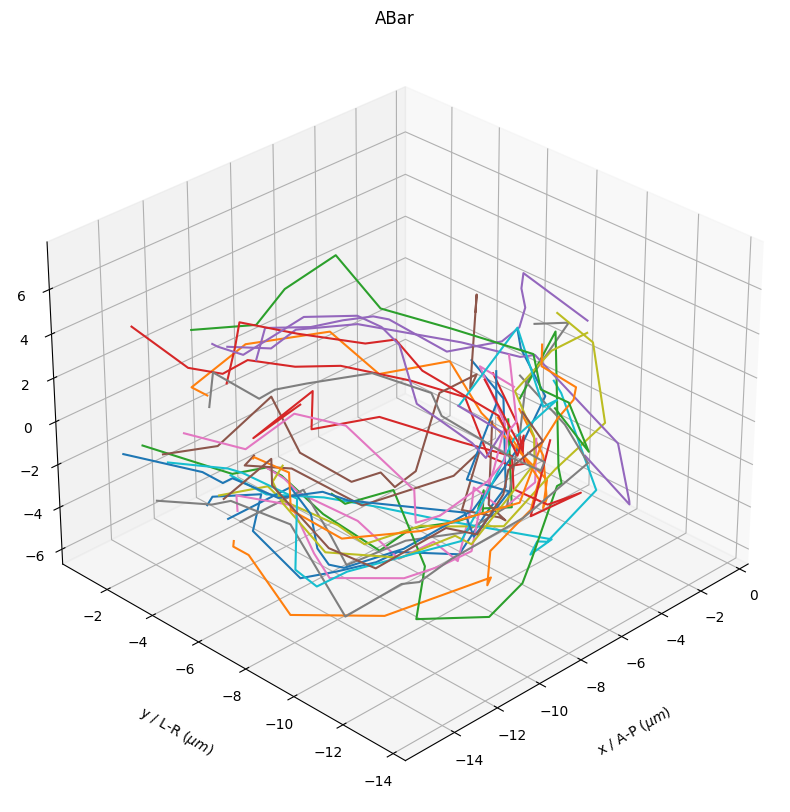

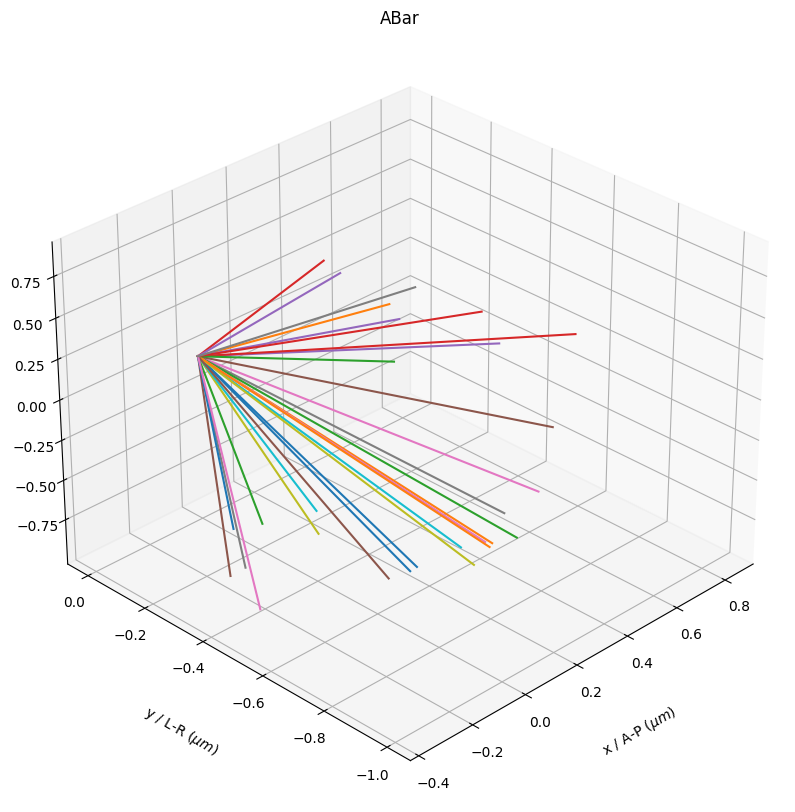

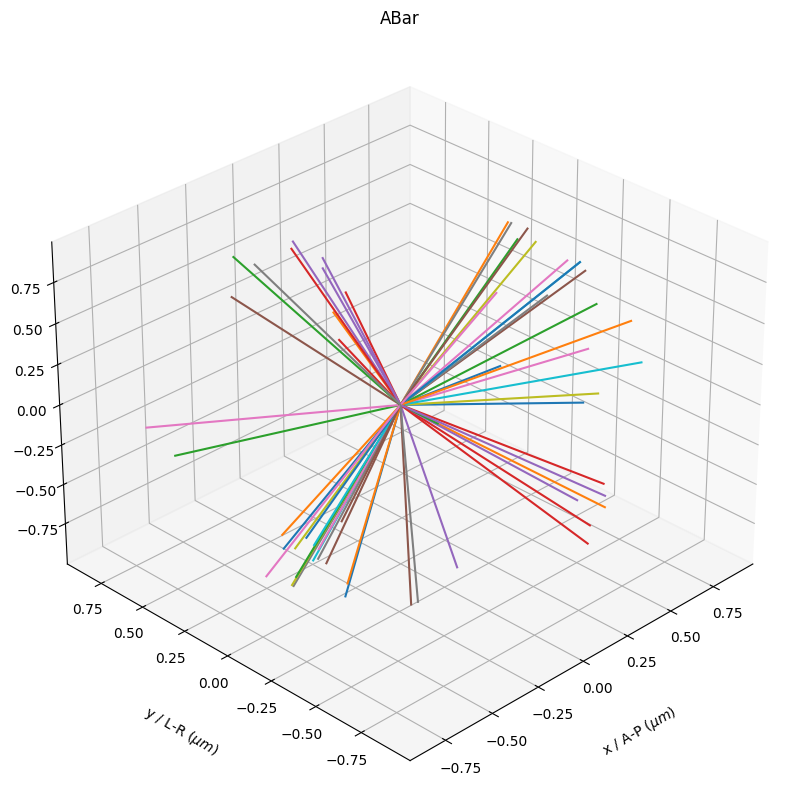

(None, None, None)

In [34]:
cell = 'ABar'
_utilities.plot_cell_trajectory(cells_info, cell), _utilities.plot_cell_division_orientation_to_mother_cell(cells_info, cell), _utilities.plot_cell_division_orientation_of_daughter_cells(cells_info, cell)

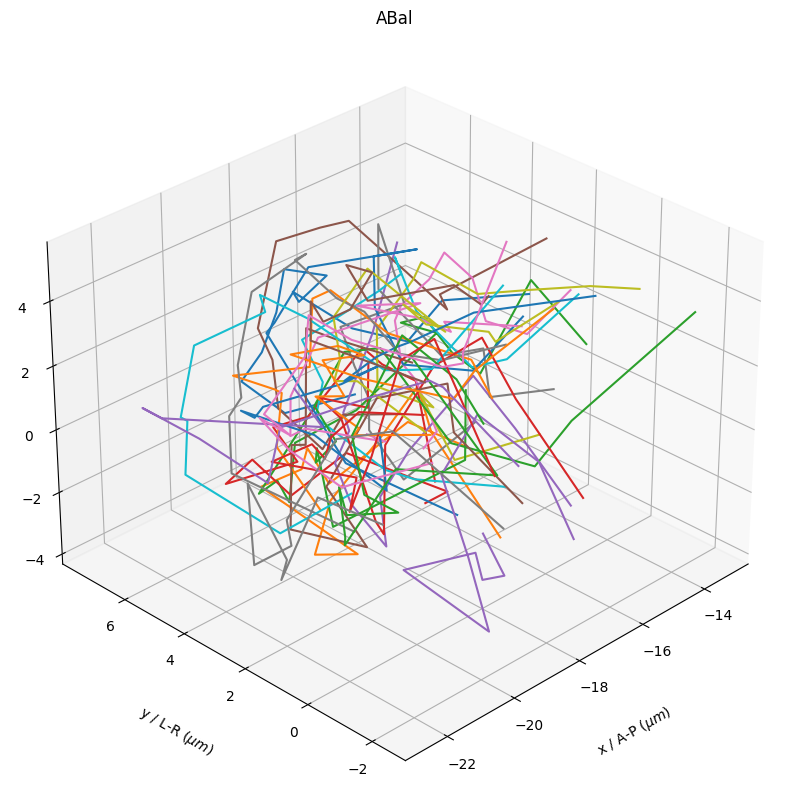

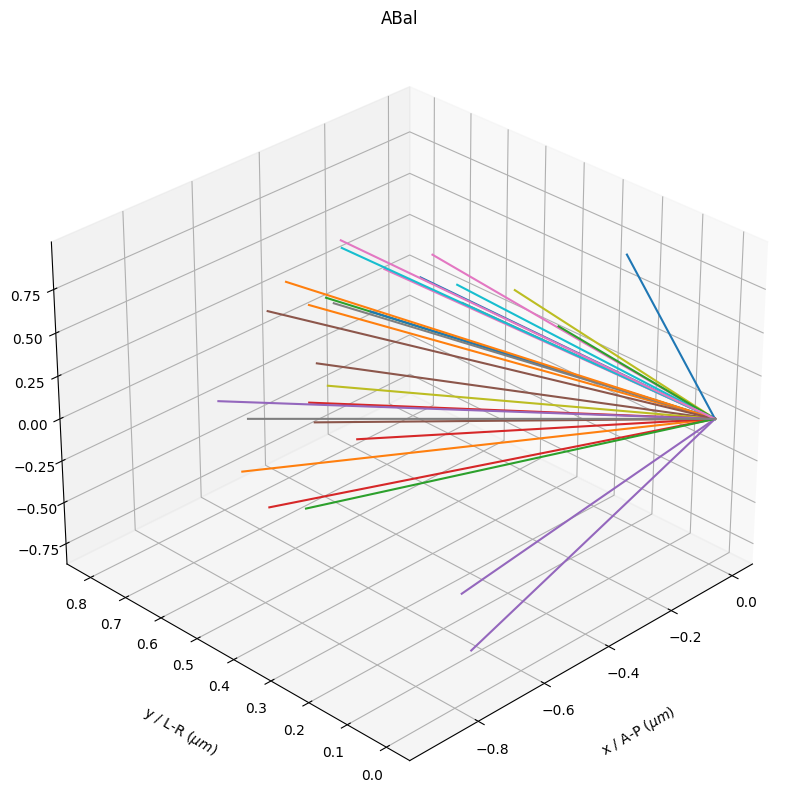

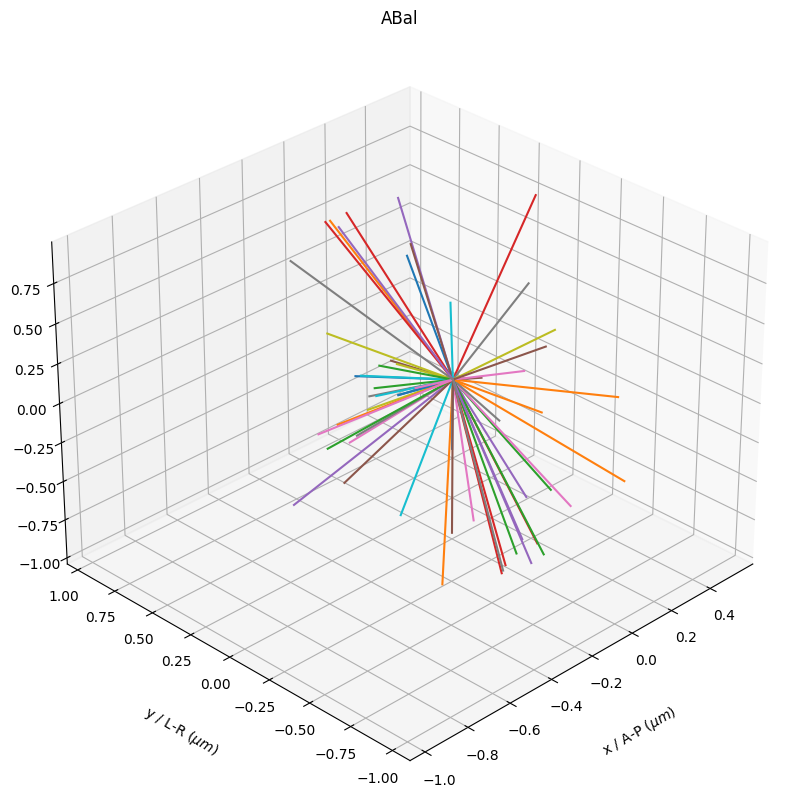

(None, None, None)

In [35]:
cell = 'ABal'
_utilities.plot_cell_trajectory(cells_info, cell), _utilities.plot_cell_division_orientation_to_mother_cell(cells_info, cell), _utilities.plot_cell_division_orientation_of_daughter_cells(cells_info, cell)

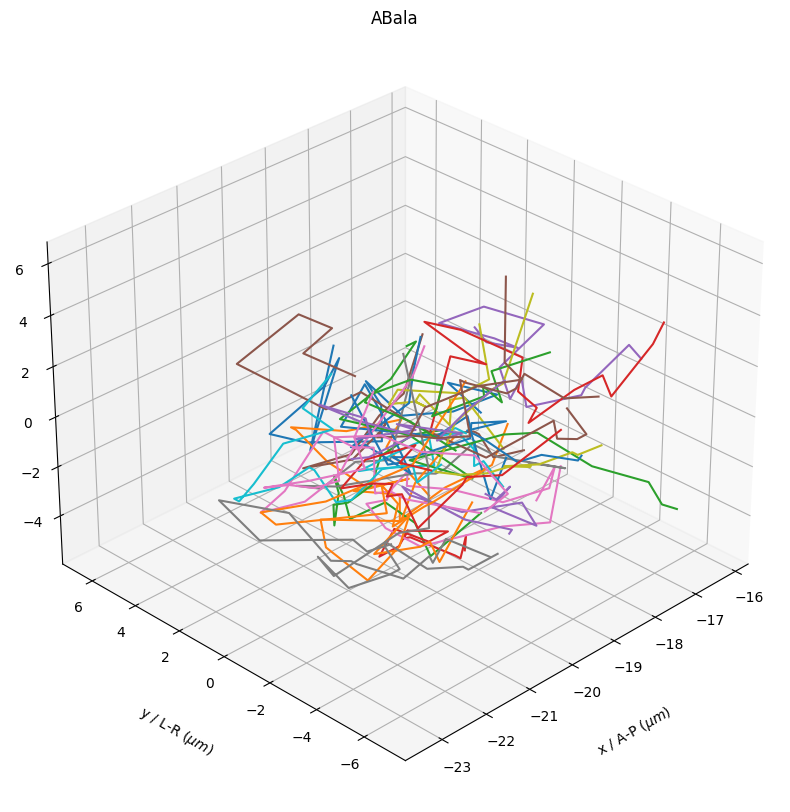

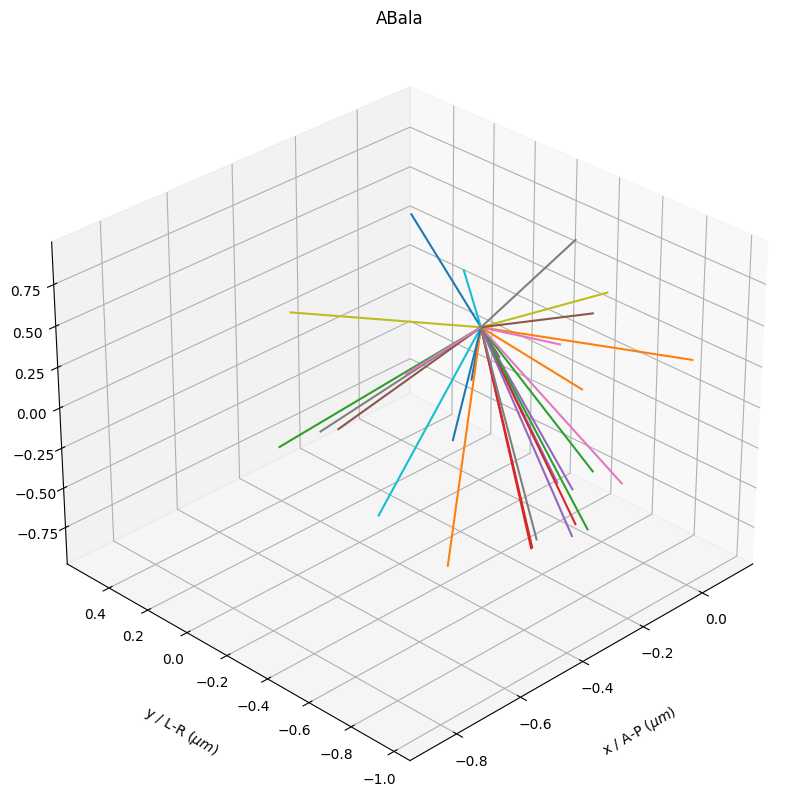

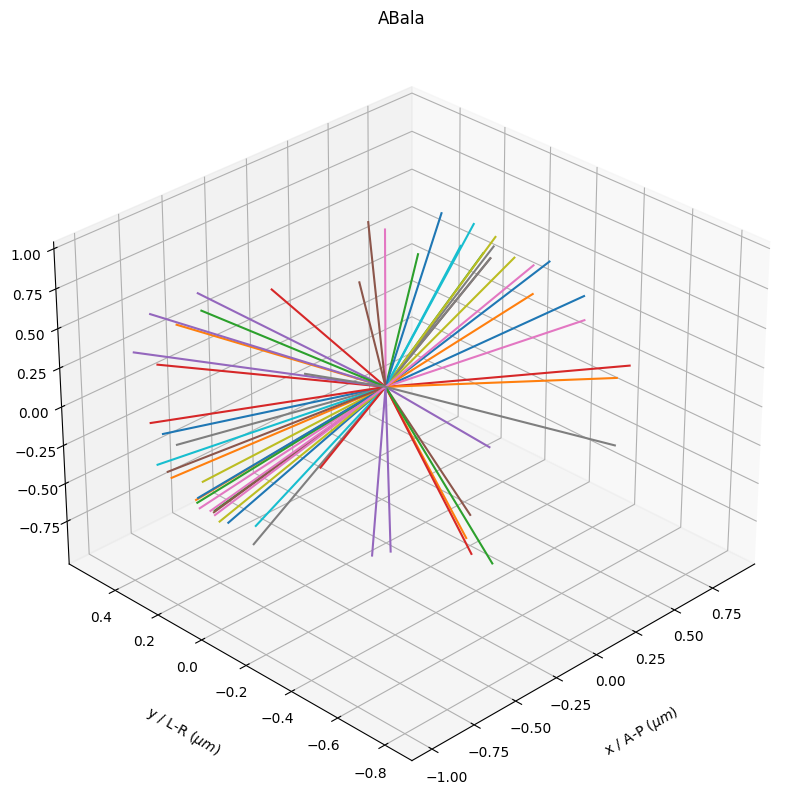

(None, None, None)

In [36]:
cell = 'ABala'
_utilities.plot_cell_trajectory(cells_info, cell), _utilities.plot_cell_division_orientation_to_mother_cell(cells_info, cell), _utilities.plot_cell_division_orientation_of_daughter_cells(cells_info, cell)

# Prepare data for train and test

In [37]:
with open( './cells_of_interest.json', 'r') as f:
   cells_of_interest = json.load(f)

In [38]:
len(cells_of_interest)

334

For each cell in cells_of_interest ($334$ cells in total), it appears in all 28 embryo samples, has mother and daughter cells, and its lifespan_frame <= 50. For our model, we need to prepare the data. The features we consider for each cell will be:
1. trajectory (frame, x, y, z) --- (50,3) or (50,4) --- depends on model architecture, we may omit frame dimension if use RNN alike architecture.
2. start_frame --- 1
3. lifespan_frame --- 1
4. division_orientation_to_mother_cell --- 3 
5. division_orientation_of_daughter_cells --- (2,3)

We process trajectory with RNN or MLP, then concatenate with other features for final prediction. So for final prediction, we have $1+1+1+3+2\times3 = 12$ features.

We need to think of a way to partition the data samples of 28 embryos, of 334 cells:
- 24 samples of embryos for cross-validation
- 4 remaining embryos for test   